# Dealing with Panel Data (Time Series and Cross-Section) in Finance

In finance, especially in forecasting, we use time series or panel data. Time series data is mostly very easy to deal with. This is because we are tracking one variable over time.

What if we were tracking a variable over time and firms? We would now have to indexers for our variables, which we call panel data.

The below example uses Compustat data. The raw data tracks annual fundamental data over the period: 2017-2020, across many firms. We will see how to deal with panel data in finance. We will be using the data set we obtain at the end of this code for Assignment 2.

## Import Library and Data

In [37]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler 
import missingno as msno

In [38]:
# ! gdown --id 1jb3oxr6Pbwu3GPd1bJn8RlacS0pOSv77

In [39]:
df=pd.read_csv('df_hw.csv')
df.head()

,Unnamed: 0,permno,exchcd,shrcd,ret,acc,agr,cfp,ep,ni,...,operprof,capxint,chpm,alm,hire,herf,bm_ia,me_ia,ffi12,fyear
0,0,10032,3,11,-0.015975,NaN,0.119131,0.078191,0.055671,0.000209,...,0.178622,0.020598,0.014426,0.416017,0.142857,0.727377,1.180605,0.026592,6,2017.0
1,1,55597,1,11,-0.005877,0.005842,0.067161,0.052896,0.011175,0.007889,...,0.191929,0.037949,-0.016507,0.175209,0.058824,0.123350,0.931938,0.338751,3,2017.0
2,2,80575,1,11,-0.046883,-0.003278,0.058725,0.049405,0.036281,-0.014695,...,0.197794,0.057538,-0.009467,0.142822,0.096335,0.064086,0.589591,0.987700,3,2017.0
3,3,25778,3,11,0.240112,0.005994,0.035686,0.046193,0.025747,-0.003276,...,0.245913,0.003740,-0.079625,0.340250,-0.042373,0.237726,0.739767,2.721329,6,2017.0
4,4,75654,3,11,-0.110406,0.005153,0.240001,0.024275,0.022150,0.009433,...,0.287046,0.024719,-0.050827,0.033750,0.246305,0.136111,0.404079,0.783007,6,2017.0


In [40]:
df=df.iloc[:,1:]

## Data Cleanup, Subsetting, and Generating Lags



In [41]:
df.drop(['exchcd','shrcd','ffi12'],axis=1,inplace=True)
df.set_index(['permno','fyear'],inplace=True)

<AxesSubplot:>

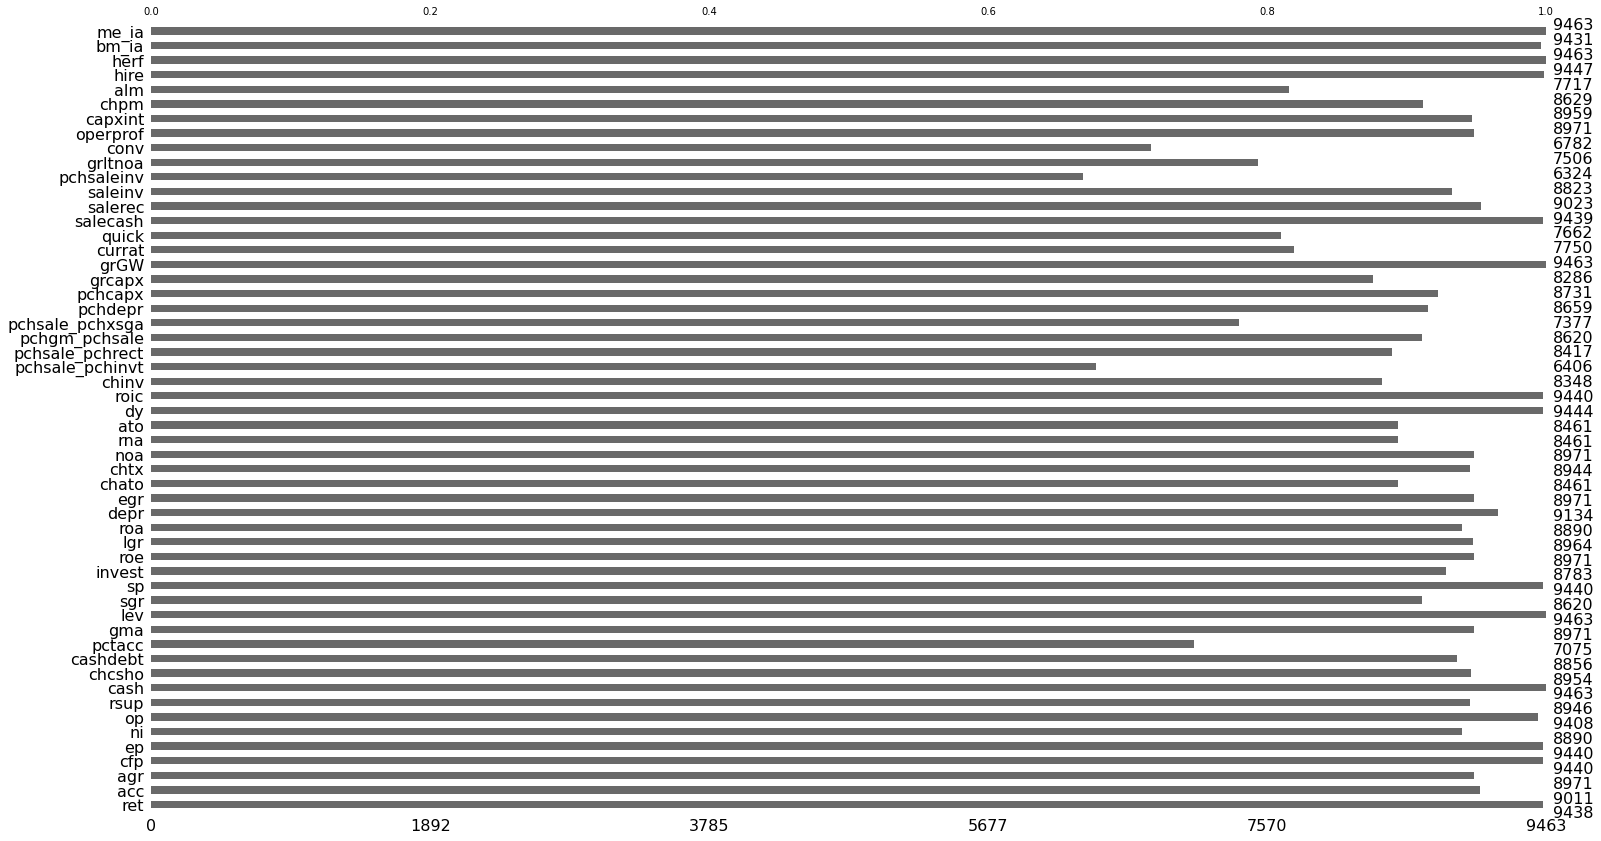

In [42]:
msno.bar(df)

In [43]:
df=df.dropna(subset=['gma'])

In [44]:
df_lagged = df.groupby('permno').shift(1)
df_lagged.drop('gma',axis=1,inplace=True)
df_gma = df[['gma']]
df=pd.concat([df_gma,df_lagged],axis=1)
df.replace([np.inf,-np.inf],np.nan,inplace=True)
df=df.dropna()
df=df.reset_index()

In [45]:
df_train_valid=df[df['fyear']<=2019]
df_train_valid.set_index(['permno','fyear'],inplace=True)
df_train_valid_label = df_train_valid[['gma']]
df_train_valid.drop('gma',axis=1,inplace=True)


df_test=df[df['fyear']==2020]
df_test.set_index(['permno','fyear'],inplace=True)
df_test_label = df_test[['gma']]
df_test.drop('gma',axis=1,inplace=True)

/var/folders/hn/l61q_f8s7nlgg9ybvy7tmlx40000gn/T/ipykernel_29624/1554595212.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_valid.drop('gma',axis=1,inplace=True)
/var/folders/hn/l61q_f8s7nlgg9ybvy7tmlx40000gn/T/ipykernel_29624/1554595212.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop('gma',axis=1,inplace=True)


In [46]:
import typing

class SklearnWrapper:
    def __init__(self, transformation: typing.Callable):
        self.transformation = transformation
        self._group_transforms = []
        # Start with -1 and for each group up the pointer by one
        self._pointer = -1

    def _call_with_function(self, df: pd.DataFrame, function: str):
        # If pointer >= len we are making a new apply, reset _pointer
        if self._pointer >= len(self._group_transforms):
            self._pointer = -1
        self._pointer += 1
        return pd.DataFrame(
            getattr(self._group_transforms[self._pointer], function)(df.values),
            columns=df.columns,
            index=df.index,
        )

    def fit(self, df):
        self._group_transforms.append(self.transformation.fit(df.values))
        return self

    def transform(self, df):
        return self._call_with_function(df, "transform")

    def fit_transform(self, df):
        self.fit(df)
        return self.transform(df)



In [47]:
scaler=SklearnWrapper(StandardScaler())

## Categorizing Profitability: Going from a continuous variable to a categorical varibale

In [48]:
df_train_valid_label=pd.DataFrame(df_train_valid_label.groupby('fyear').apply(scaler.fit_transform))
df_train_valid_label['label'] =df_train_valid_label['gma'].astype(int)
df_train_valid_label.head()

,,gma,label
permno,fyear,,
15417,2018.0,0.564012,0
89031,2018.0,1.676655,1
11154,2018.0,-0.646399,0
13556,2018.0,-0.075451,0
14296,2018.0,0.771351,0


In [49]:
df_train_valid_label=df_train_valid_label.iloc[:,1]

In [50]:
df_test_label=pd.DataFrame(df_test_label.groupby('fyear').apply(scaler.fit_transform))
df_test_label['label'] =df_test_label['gma'].astype(int)
df_test_label.head()

,,gma,label
permno,fyear,,
12211,2020.0,-0.237420,0
82777,2020.0,1.067435,1
89216,2020.0,0.370074,0
27684,2020.0,-0.556317,0
80320,2020.0,0.205453,0


In [51]:
df_test_label=df_test_label.iloc[:,1]

In [52]:
df_label = pd.concat([df_train_valid_label,df_test_label],axis=0)

In [53]:
df_label.head()

permno  fyear 
15417   2018.0    0
89031   2018.0    1
11154   2018.0    0
13556   2018.0    0
14296   2018.0    0
Name: label, dtype: int64